In [156]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statistics import mean, median
from math import sqrt
from scipy.stats import mannwhitneyu
from typing import Tuple, List, Dict, Set, Iterable
import matplotlib.style as mpl_style
import os
import json


In [157]:
# path to csv results
AIRFOIL_PATH = "./results.csv"

In [158]:
def df_from_path(path: str) -> pd.DataFrame:
    return pd.read_csv(
        filepath_or_buffer=path,
        sep="?",
    )

AIRFOIL_RESULTS = df_from_path(AIRFOIL_PATH)
AIRFOIL_RESULTS.tail()

directory rund_id  test_no  generation  \
1111  grow_pt_dae_gp  3_7397        3          26   
1112  grow_pt_dae_gp  3_7397        3          27   
1113  grow_pt_dae_gp  3_7397        3          28   
1114  grow_pt_dae_gp  3_7397        3          29   
1115  grow_pt_dae_gp  3_7397        3          30   

      after_selection_depth_25percentile  after_selection_depth_50percentile  \
1111                                 0.0                                 0.0   
1112                                 0.0                                 0.0   
1113                                 0.0                                 0.0   
1114                                 0.0                                 0.0   
1115                                 0.0                                 0.0   

      after_selection_depth_75percentile after_selection_depth_algorithm  \
1111                                 0.0                        DAE_LSTM   
1112                                 0.0                        DAE_LSTM   
1113                                 0.0                        DAE_LSTM   
1114                                 1.0                        DAE_LSTM   
1115                                 0.0                        DAE_LSTM   

      after_selection_depth_avg  \
1111                      0.338   
1112                      0.304   
1113                      0.326   
1114                      0.384   
1115                      0.346   

      after_selection_depth_avg_lev_distance_denoising  ...  training_error  \
1111                                             0.158  ...           0.027   
1112                                             0.188  ...           0.028   
1113                                             0.174  ...           0.029   
1114                                             0.176  ...            0.03   
1115                                             0.170  ...            0.03   

      training_errors  training_mode unique  unique_output_vector_rate  \
1111             None    convergence    127                      0.158   
1112             None    convergence    129                      0.172   
1113             None    convergence    148                      0.180   
1114             None    convergence    132                      0.146   
1115             None    convergence    120                      0.130   

      unique_output_vector_rate_int  unique_output_vector_rate_sel  \
1111                          0.112                          0.074   
1112                          0.114                          0.094   
1113                          0.110                          0.102   
1114                          0.100                           0.11   
1115                          0.088                          0.094   

     unique_output_vector_rate_test  unique_rate  \
1111                          0.158        0.254   
1112                          0.172        0.258   
1113                          0.180        0.296   
1114                          0.146        0.264   
1115                          0.130        0.240   

      wass_norm_lev_div_sampled_vs_selected  
1111                                  0.043  
1112                                  0.024  
1113                                  0.018  
1114                                  0.008  
1115                                  0.022  

[5 rows x 787 columns]

In [159]:
def split_df(df: pd.DataFrame, dir1: str, dir2: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return df.query("directory == @dir1").copy(), df.query("directory == @dir2").copy()
    
sec_pt_results, reg_results = split_df(AIRFOIL_RESULTS, "pt_dae_gp", "dae_gp")
grow_pt_results, s_pt_results = split_df(AIRFOIL_RESULTS, "grow_pt_dae_gp", "pt_standard")

In [160]:

print(
    #sec_pt_results.shape == reg_results.shape == grow_pt_results,
    sec_pt_results.shape,
    reg_results.shape,
    grow_pt_results.shape,
    s_pt_results.shape
)


(310, 787) (248, 787) (310, 787) (248, 787)


In [161]:
def filter_df_by_headers(df, headers):
    return df[df.columns.intersection(headers)]

In [162]:
def get_test_nums(df) -> Set[int]:
    return {x for x in df.test_no}

sec_pt_test_nums = get_test_nums(sec_pt_results)
grow_pt_test_nums = get_test_nums(grow_pt_results)
reg_test_nums = get_test_nums(reg_results)
s_pt_test_nums = get_test_nums(s_pt_results)

def get_rund_ids(df) -> Set[int]:
    return {x for x in df.rund_id}

sec_pt_rund_ids = get_rund_ids(sec_pt_results)
grow_pt_rund_ids = get_rund_ids(grow_pt_results)
s_pt_run_ids = get_rund_ids(s_pt_results)
reg_rund_ids = get_rund_ids(reg_results)

SEC_PT_NRUNS = len(sec_pt_rund_ids)
GROW_PT_NRUNS = len(grow_pt_rund_ids)
REG_NRUNS = len(reg_rund_ids)
S_PT_NRUNS = len(s_pt_run_ids)

print(f"2nd. Gen Pre-Trained Runs: {SEC_PT_NRUNS}\nRegular Runs: {REG_NRUNS}\nGrow - Pre-Trained Runs: {GROW_PT_NRUNS}\nStandard - Pre-Trained Runs {S_PT_NRUNS}")

2nd. Gen Pre-Trained Runs: 10
Regular Runs: 8
Grow - Pre-Trained Runs: 10
Standard - Pre-Trained Runs 8


In [163]:
D = {
    "hidden_layers": 2,
    "hidden_dim": 150,
    "gen_max": 30,
    "n_runs":10
}

def validate(D: Dict, df: pd.DataFrame):

    def check_hidden_layers(df: pd.DataFrame, value: str) -> bool:
        return all(df['hidden_layers'] == value)

    print("Correct number of Hidden Layers: ", check_hidden_layers(df, D["hidden_layers"]))

    def check_hidden_dim(df: pd.DataFrame, value: int) -> bool:
        df["hidden_dim"] = pd.to_numeric(df["hidden_dim"], errors='coerce').fillna(0)
        for hidden_dim in df["hidden_dim"].values:
            if not (int(hidden_dim) in {value, 0}):
                return False
        return True

    print("Correct number of Hidden Neurons: ", check_hidden_dim(df, D["hidden_dim"]))


    def check_generations_range(df: pd.DataFrame, minimum: int, maximum: int) -> bool:
        return all(df['generation'] >= minimum) and all(df['generation'] <= maximum)

    print("Correct number of Generations: ", check_generations_range(df, 0, D["gen_max"]))

    def get_ind_rund_ids(df):
        return len({x for x in df.rund_id})

    print("Minimum number of Runs reached: ", get_ind_rund_ids(df) >= D["n_runs"])


print("Regular Results:\n...")
validate(D, reg_results) 
print("\n2nd. Gen Pre-trained Results:\n...")
validate(D, sec_pt_results)
print("\nGrow Pre-trained Results:\n...")
validate(D, grow_pt_results)
print()
print("\nStandard Pre-trained Results:\n...")
validate(D, s_pt_results)
print()

Regular Results:
...
Correct number of Hidden Layers:  True
Correct number of Hidden Neurons:  True
Correct number of Generations:  True
Minimum number of Runs reached:  False

2nd. Gen Pre-trained Results:
...
Correct number of Hidden Layers:  True
Correct number of Hidden Neurons:  True
Correct number of Generations:  True
Minimum number of Runs reached:  True

Grow Pre-trained Results:
...
Correct number of Hidden Layers:  True
Correct number of Hidden Neurons:  True
Correct number of Generations:  True
Minimum number of Runs reached:  True


Standard Pre-trained Results:
...
Correct number of Hidden Layers:  True
Correct number of Hidden Neurons:  True
Correct number of Generations:  True
Minimum number of Runs reached:  False



In [164]:
def get_vals(df, vals, gens):

    ret = []

    def filter_df_by_col_val(df, col, val):
        return df[df[col] == val]

    def get_rund_ids(df) -> Set[int]:
        return {x for x in df.rund_id}
    
    run_ids = get_rund_ids(df)

    for i, id in enumerate(run_ids):

        _df = filter_df_by_col_val(df, "rund_id", id)

        ret.append([])

        for gen in range(0,gens+1):

            __df = filter_df_by_col_val(_df, "generation", gen)


            ret[i].append(
                __df[vals].values[0]
            )
    return ret


reg_fits = get_vals(reg_results, "best_fitness", 30)
reg_fits_test = get_vals(reg_results, "best_fitness_test", 30)

sec_pt_fits = get_vals(sec_pt_results, "best_fitness", 30)
sec_pt_fits_test = get_vals(sec_pt_results, "best_fitness_test", 30)


grow_pt_fits = get_vals(grow_pt_results, "best_fitness", 30)
grow_pt_fits_test = get_vals(grow_pt_results, "best_fitness_test", 30)

s_pt_fits = get_vals(s_pt_results, "best_fitness", 30)
s_pt_fits_test = get_vals(s_pt_results, "best_fitness_test", 30)




def get_means(arr):

    ret = []

    for gen in range(0, 31):

        gen_fits=[]

        for run in range(0, len(arr)):

            gen_fits.append(arr[run][gen])
    
        ret.append(mean(gen_fits))

    return ret
        

def get_medians(arr):

    ret = []

    for gen in range(0, 31):

        gen_fits=[]

        for run in range(0, len(arr)):

            gen_fits.append(arr[run][gen])
    
        ret.append(median(gen_fits))

    return ret


In [165]:
DATAPATH = "/Users/rmn/masterThesis/master_thesis/data/PT_Strategies_airfoil_2hl_150hn_fullRun"

def writeMWU(dir_name: str, file_name:str, sample1: Iterable, sample2: Iterable):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    statistic, pval = mannwhitneyu(x=sample1, y=sample2)

    S = {
        "statistic" : statistic,
        "p-value"   : pval
    }
    print(S)

    json.dump(
        S,
        open(os.path.join(dir_name, f"{file_name}.json"), "w", encoding="utf-8"),
    )

def writeData(dir_name: str, file_name:str, D: Dict):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


    # for key,val in D.items():
    #     try:
    #         print(len(val))
    #     except:
    #         print(None)

    json.dump(
        D,
        open(os.path.join(dir_name, f"{file_name}.json"), "w", encoding="utf-8"),
    )

In [166]:
from json import load

MPL_CONFIG = load(
    open("/Users/rmn/masterThesis/eda-gp-2020/experiments/matplotlib_config.json", "r", encoding="utf-8")
)


mpl_style.use(MPL_CONFIG["mpl_style"])

# font sizes
SMALL=MPL_CONFIG["fonts"]["small"]
MID=MPL_CONFIG["fonts"]["mid"]
BIG=MPL_CONFIG["fonts"]["big"]

# color codes
C_REG=MPL_CONFIG["colors"]["dae-gp"]
C_PT=MPL_CONFIG["colors"]["pt_dae-gp"]
C_GP=MPL_CONFIG["colors"]["gp"]
C_SPT="m"

# marker codes
M_TRAIN=MPL_CONFIG["marker"]["train"]
M_TEST=MPL_CONFIG["marker"]["test"]

TRAIN_LINESTYLE=MPL_CONFIG["train_line_style"]

DPI=MPL_CONFIG["dpi"]


IMG_PATH=f"{MPL_CONFIG['image_base_path']}/PT_Strategies_airfoil_2hl_150hn_fullRun"

def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

create_dir(IMG_PATH)
BASE_TITLE="Airfoil - Pre-Training Strategies"

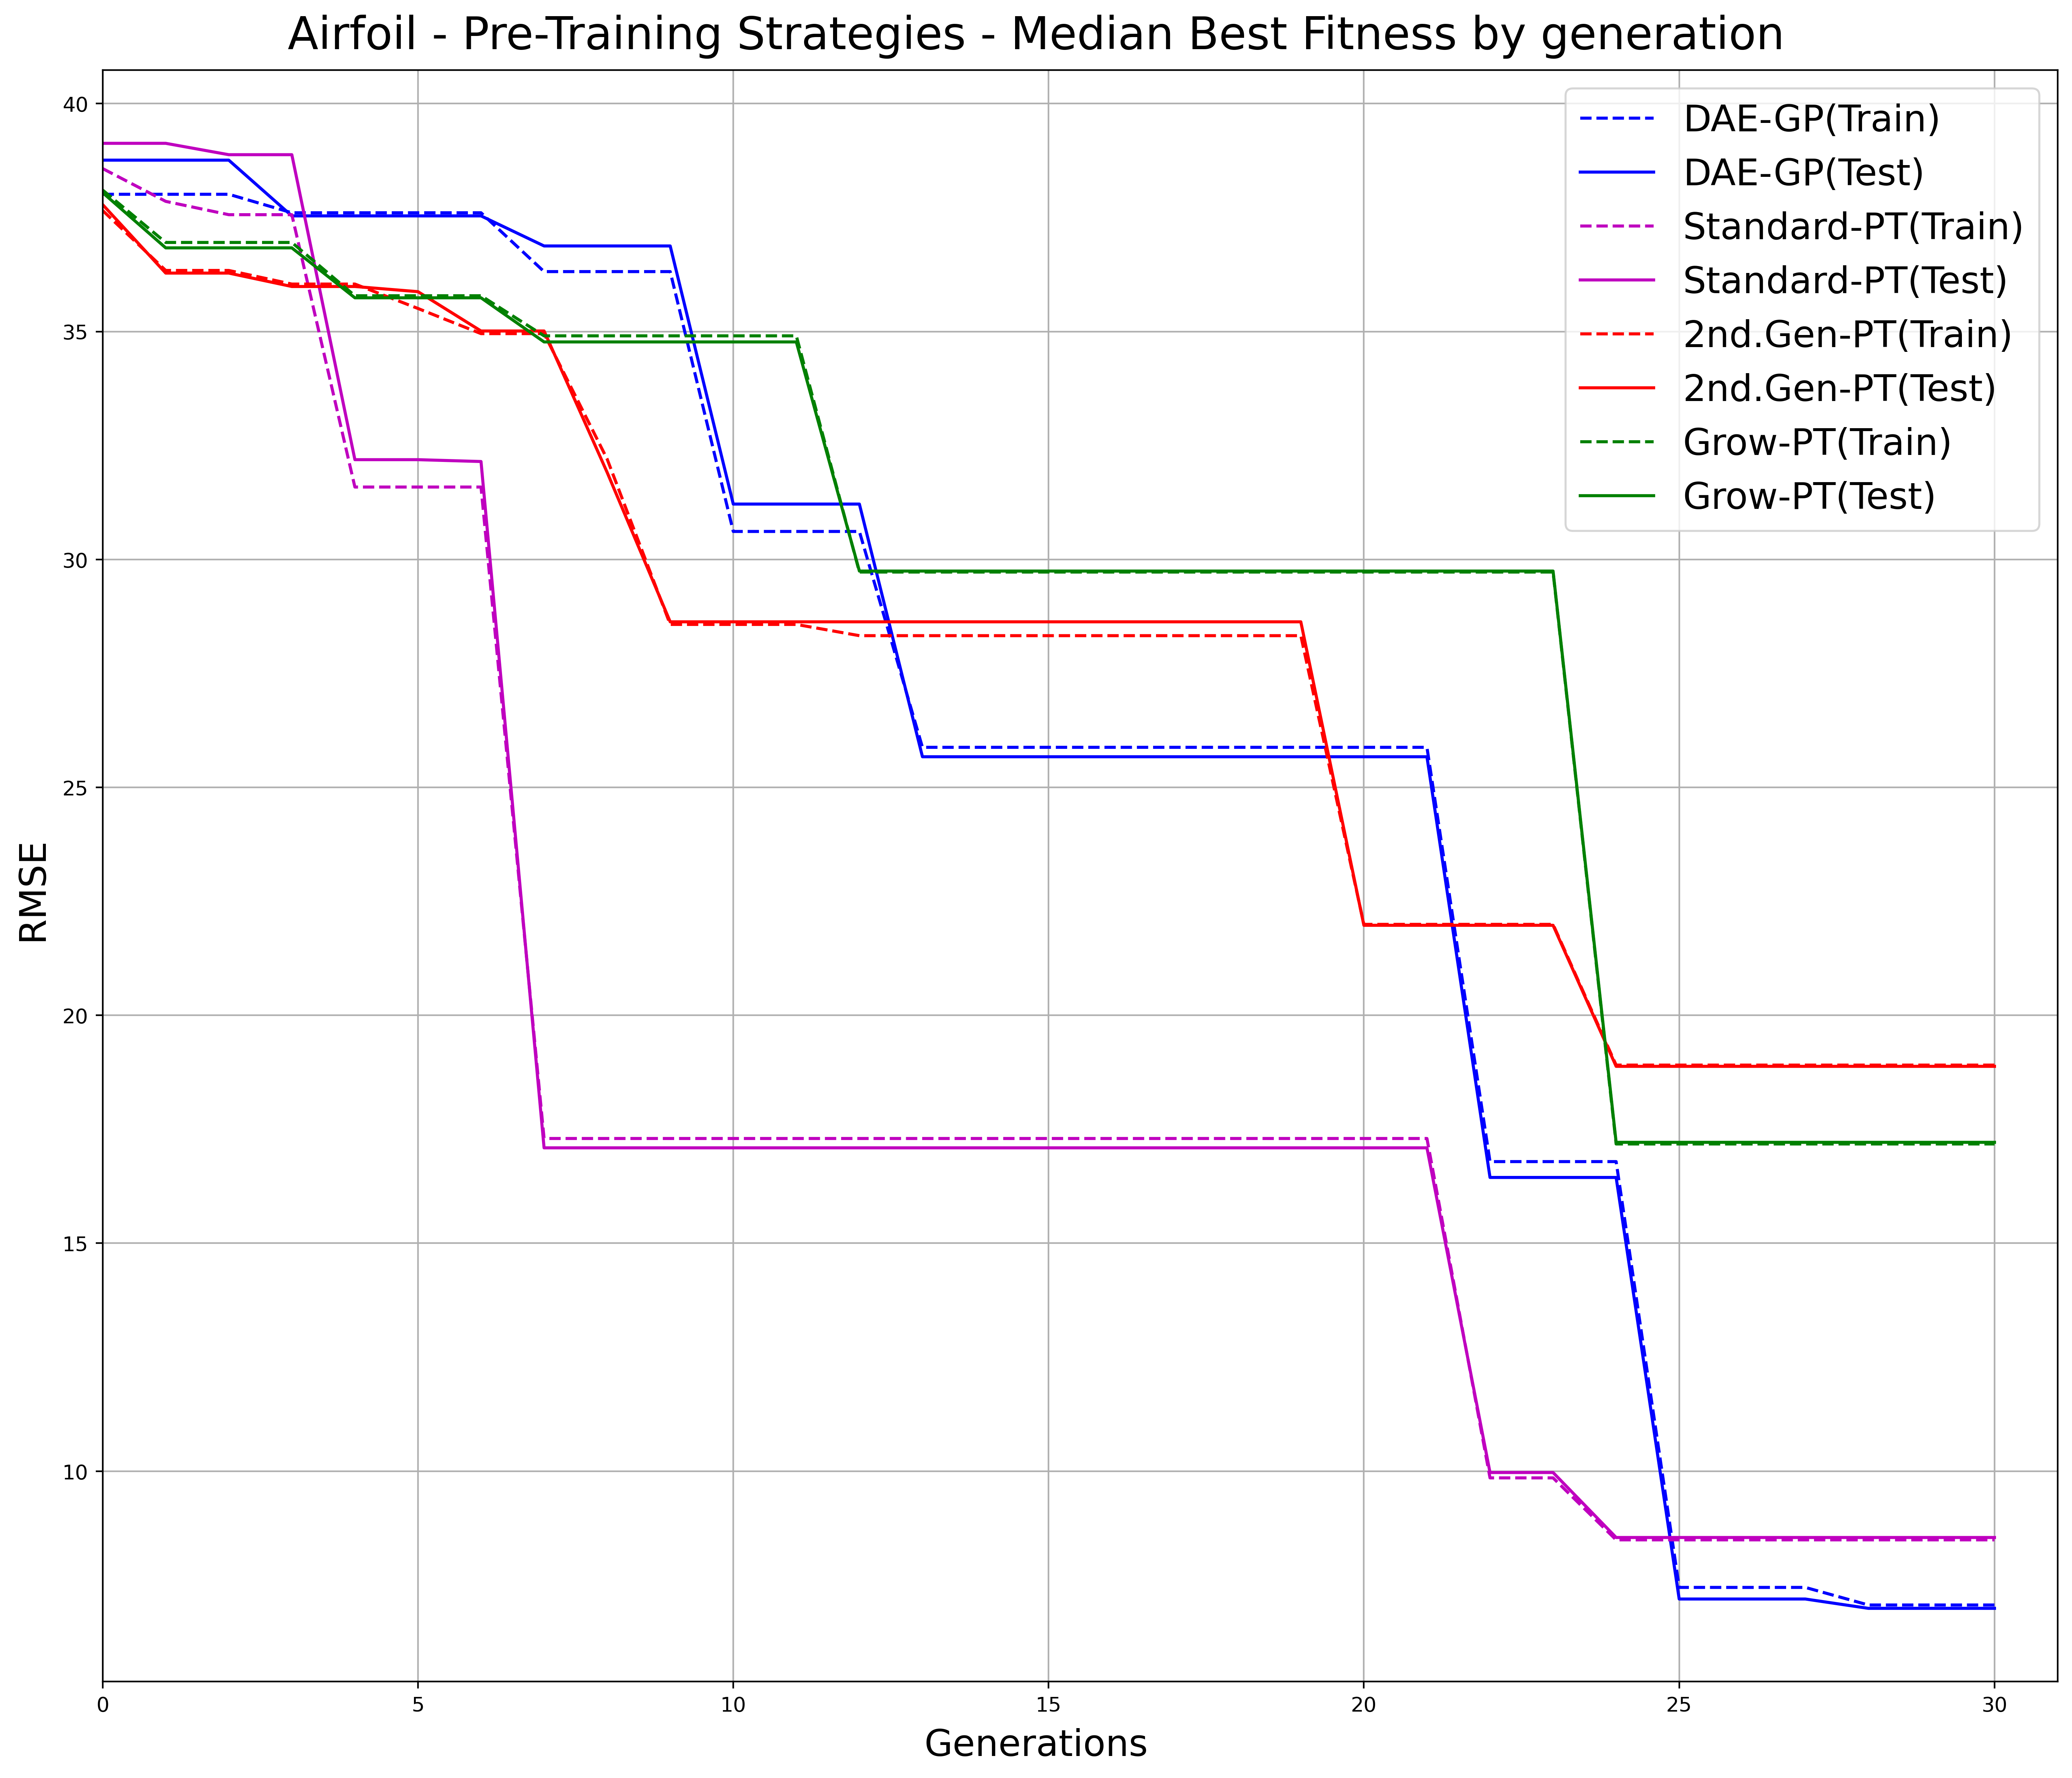

In [167]:
fig, ax = plt.subplots(ncols=1, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]



fig.suptitle(f"{BASE_TITLE} - Median Best Fitness by generation", fontsize=BIG)
fig.supxlabel("Generations", fontsize=MID)
fig.supylabel("RMSE", fontsize=MID)

ax.set_xlim(0,31)


ax.plot(gens, np.median(reg_fits,axis=0), color=C_REG, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Train)")
ax.plot(gens, np.median(reg_fits_test, axis=0), color=C_REG, marker=M_TEST, label="DAE-GP(Test)")

ax.plot(gens, np.median(s_pt_fits,axis=0), color=C_SPT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Standard-PT(Train)")
ax.plot(gens, np.median(s_pt_fits_test, axis=0), color=C_SPT, marker=M_TEST, label="Standard-PT(Test)")

ax.plot(gens, np.median(sec_pt_fits,axis=0), color=C_PT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="2nd.Gen-PT(Train)")
ax.plot(gens, np.median(sec_pt_fits_test, axis=0), color=C_PT, marker=M_TEST, label="2nd.Gen-PT(Test)")

ax.plot(gens, np.median(grow_pt_fits,axis=0), color=C_GP, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Grow-PT(Train)")
ax.plot(gens, np.median(grow_pt_fits_test, axis=0), color=C_GP, marker=M_TEST, label="Grow-PT(Test)")




ax.legend(fontsize=MID)
ax.grid()


fig.savefig(f"{IMG_PATH}/median_fitness_byGens.png")

D = {
    "problem": "Airfoil",
    "hiddenLayer": 2,
    "DAE-GP(train)" : reg_fits,
    "DAE-GP(test)" : reg_fits_test,
    "2nd.Gen-PT(train)" : sec_pt_fits,
    "2nd.Gen-PT(test)" : sec_pt_fits_test,
    "Grow-PT(train)" : grow_pt_fits,
    "Grow-PT(test)" : grow_pt_fits_test,
    "Standard-PT(train)" : s_pt_fits,
    "Standard-PT(test)" : s_pt_fits_test,


}

writeData(DATAPATH, "fitness_per_gen", D)

In [168]:
fig, ax = plt.subplots(ncols=1, layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]



fig.suptitle(f"{BASE_TITLE} - Mean Best Fitness by generation", fontsize=BIG)
fig.supxlabel("Generations", fontsize=MID)
fig.supylabel("RMSE", fontsize=MID)

ax.set_xlim(0,31)


ax.plot(gens, np.mean(reg_fits,axis=0), color=C_REG, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="DAE-GP(Train)")
ax.plot(gens, np.mean(reg_fits_test, axis=0), color=C_REG, marker=M_TEST, label="DAE-GP(Test)")

ax.plot(gens, np.mean(s_pt_fits,axis=0), color=C_SPT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Standard-PT(Train)")
ax.plot(gens, np.mean(s_pt_fits_test, axis=0), color=C_SPT, marker=M_TEST, label="Standard-PT(Test)")

ax.plot(gens, np.mean(sec_pt_fits,axis=0), color=C_PT, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="2nd.Gen-PT(Train)")
ax.plot(gens, np.mean(sec_pt_fits_test, axis=0), color=C_PT, marker=M_TEST, label="2nd.Gen-PT(Test)")

ax.plot(gens, np.mean(grow_pt_fits,axis=0), color=C_GP, marker=M_TRAIN, linestyle=TRAIN_LINESTYLE, label="Grow-PT(Train)")
ax.plot(gens, np.mean(grow_pt_fits_test, axis=0), color=C_GP, marker=M_TEST, label="Grow-PT(Test)")






ax.grid()
ax.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/mean_fitness_byGens.png")

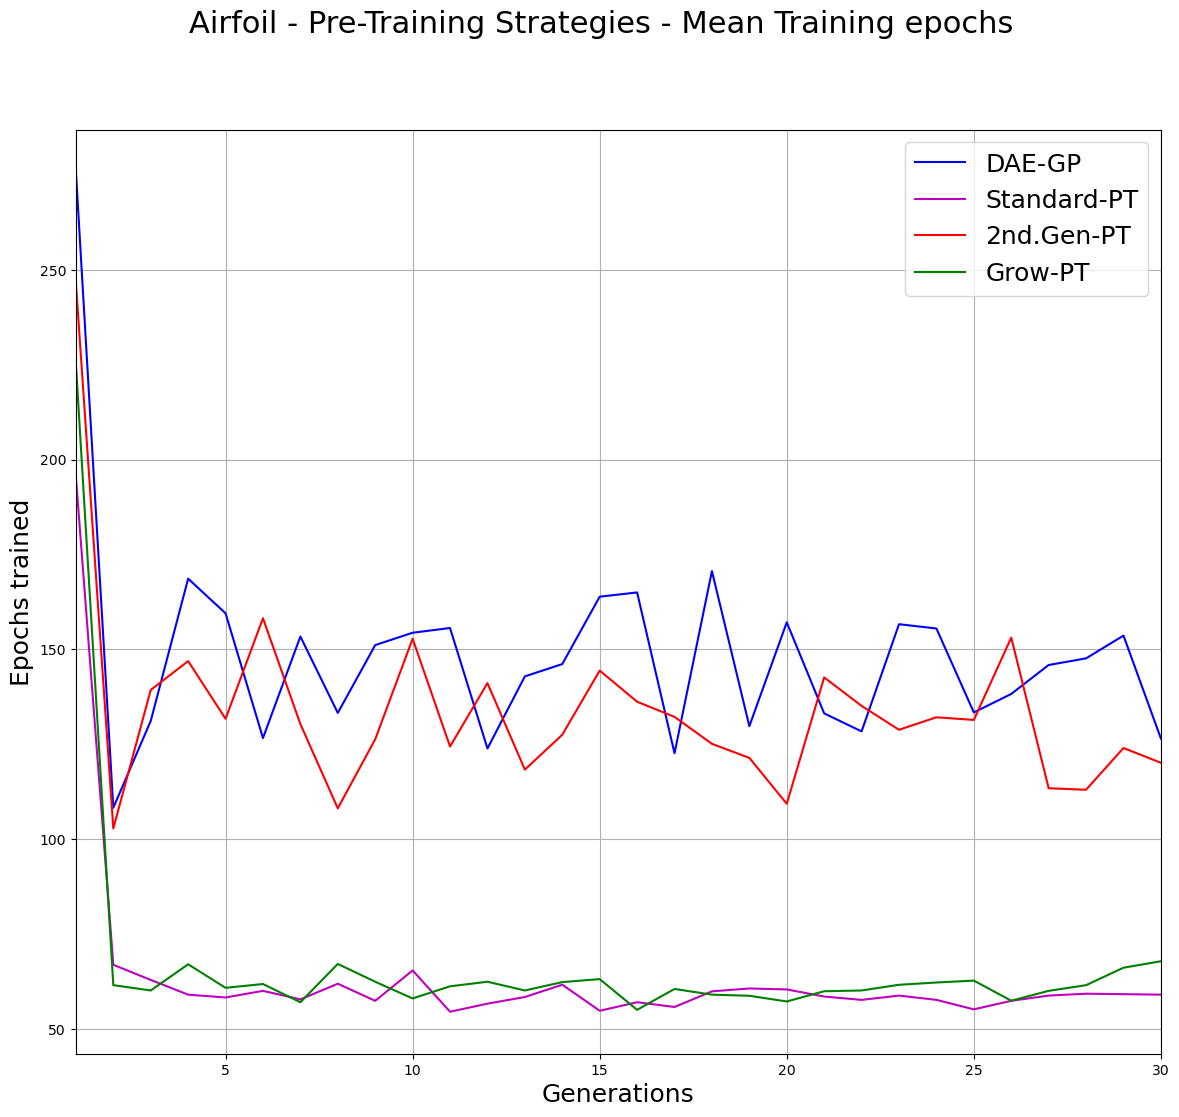

In [169]:
# mean epochs trained


reg_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(reg_results, "epochs_trained", 30)))
)
sec_pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(sec_pt_results, "epochs_trained", 30)))
)

grow_pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(grow_pt_results, "epochs_trained", 30)))
)

s_pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(s_pt_results, "epochs_trained", 30)))
)

gens = np.arange(1,31)

reg_epochs_mean = reg_epochs.mean(axis=0)
sec_pt_epochs_mean = sec_pt_epochs.mean(axis=0)
grow_pt_epochs_mean = grow_pt_epochs.mean(axis=0)
s_pt_epochs_mean = s_pt_epochs.mean(axis=0)

fig,ax = plt.subplots()
fig.set_size_inches(14,12)

fig.suptitle(f"{BASE_TITLE} - Mean Training epochs", fontsize=BIG)

#ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=1, right=30)
    
ax.plot(gens, reg_epochs_mean[1:], color=C_REG, label="DAE-GP")
ax.plot(gens, s_pt_epochs_mean[1:], color=C_SPT, label="Standard-PT")
ax.plot(gens, sec_pt_epochs_mean[1:], color=C_PT, label="2nd.Gen-PT")
ax.plot(gens, grow_pt_epochs_mean[1:], color=C_GP, label="Grow-PT")

ax.set_ylabel("Epochs trained", fontsize=MID)
ax.set_xlabel("Generations", fontsize=MID)


ax.grid()
ax.legend(fontsize=MID)

fig.savefig(f"{IMG_PATH}/mean_epochs_trained_perGen.png")

D = {
    "problem": "Airfoil",
    "hiddenLayer": 2,
    "DAE-GP" : reg_epochs.tolist(),
    "2nd.Gen-Pre-Trained" : sec_pt_epochs.tolist(),
    "Grow-Pre-Trained" : grow_pt_epochs.tolist(),
    "Standard-Pre-Trained" : s_pt_epochs.tolist(),
}

writeData(DATAPATH, "epochs_trained_perGen", D)


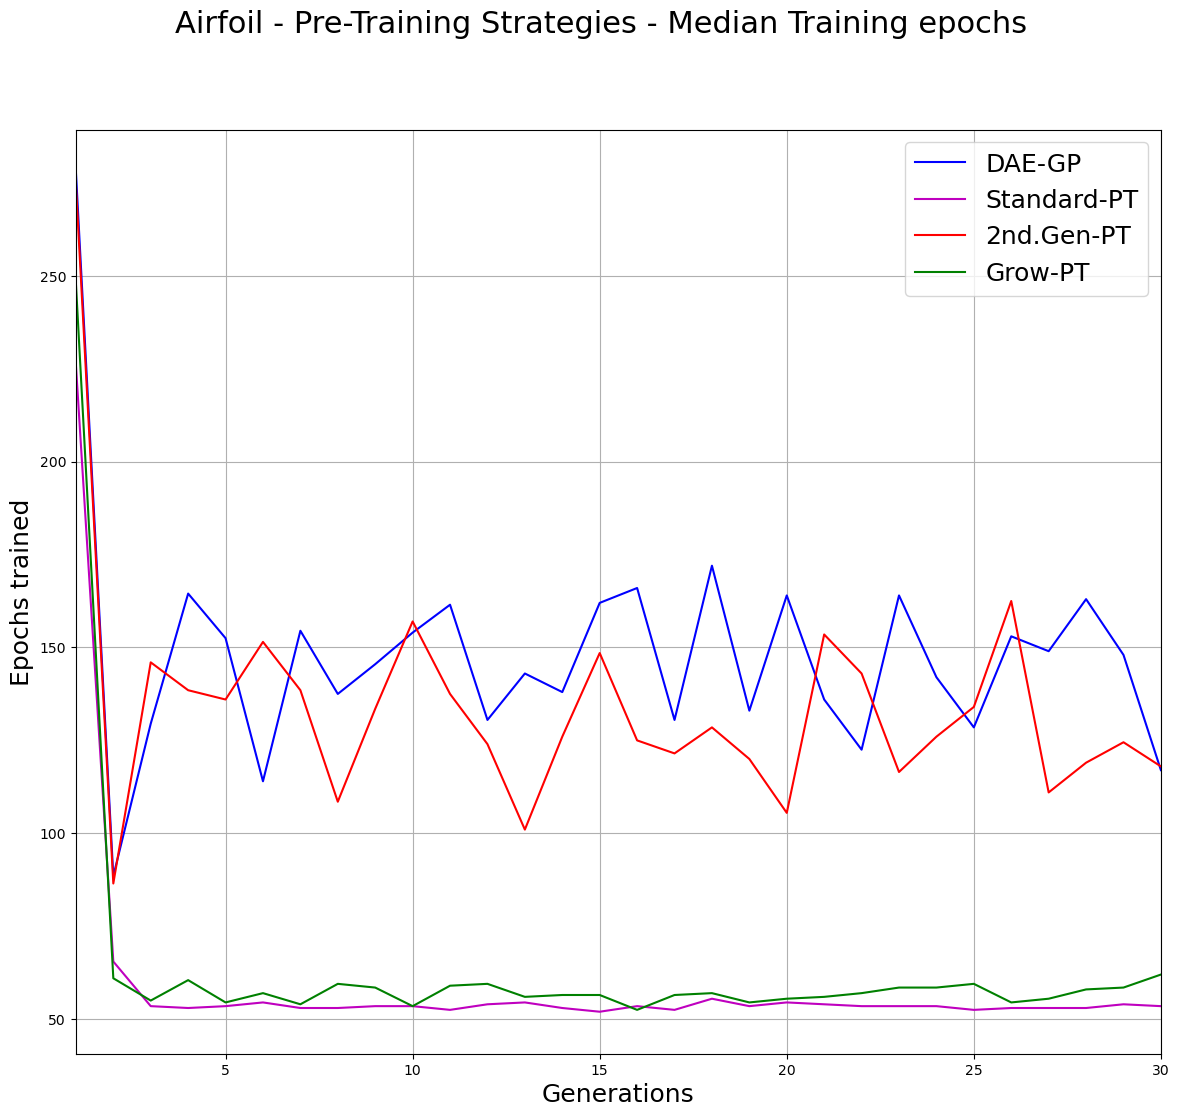

In [170]:
# median epochs trained


reg_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(reg_results, "epochs_trained", 30)))
)
sec_pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(sec_pt_results, "epochs_trained", 30)))
)

grow_pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(grow_pt_results, "epochs_trained", 30)))
)

s_pt_epochs = np.array(
    list(map(lambda x: [int(i) if i != "None" else 0 for i in x], get_vals(s_pt_results, "epochs_trained", 30)))
)


gens = np.arange(1,31)

reg_epochs_mean = np.median(reg_epochs, axis=0)
sec_pt_epochs_mean = np.median(sec_pt_epochs, axis=0)
grow_pt_epochs_mean = np.median(grow_pt_epochs, axis=0)
s_pt_epochs_mean = np.median(s_pt_epochs, axis=0)

fig,ax = plt.subplots()
fig.set_size_inches(14,12)

fig.suptitle(f"{BASE_TITLE} - Median Training epochs", fontsize=BIG)

#ax.set_ylim(bottom=0, top=1)
ax.set_xlim(left=1, right=30)
    
ax.plot(gens, reg_epochs_mean[1:], color=C_REG, label="DAE-GP")
ax.plot(gens, s_pt_epochs_mean[1:], color=C_SPT, label="Standard-PT")
ax.plot(gens, sec_pt_epochs_mean[1:], color=C_PT, label="2nd.Gen-PT")
ax.plot(gens, grow_pt_epochs_mean[1:], color=C_GP, label="Grow-PT")

ax.set_ylabel("Epochs trained", fontsize=MID)
ax.set_xlabel("Generations", fontsize=MID)


ax.grid()
ax.legend(fontsize=MID)

fig.savefig(f"{IMG_PATH}/median_epochs_trained_perGen.png")



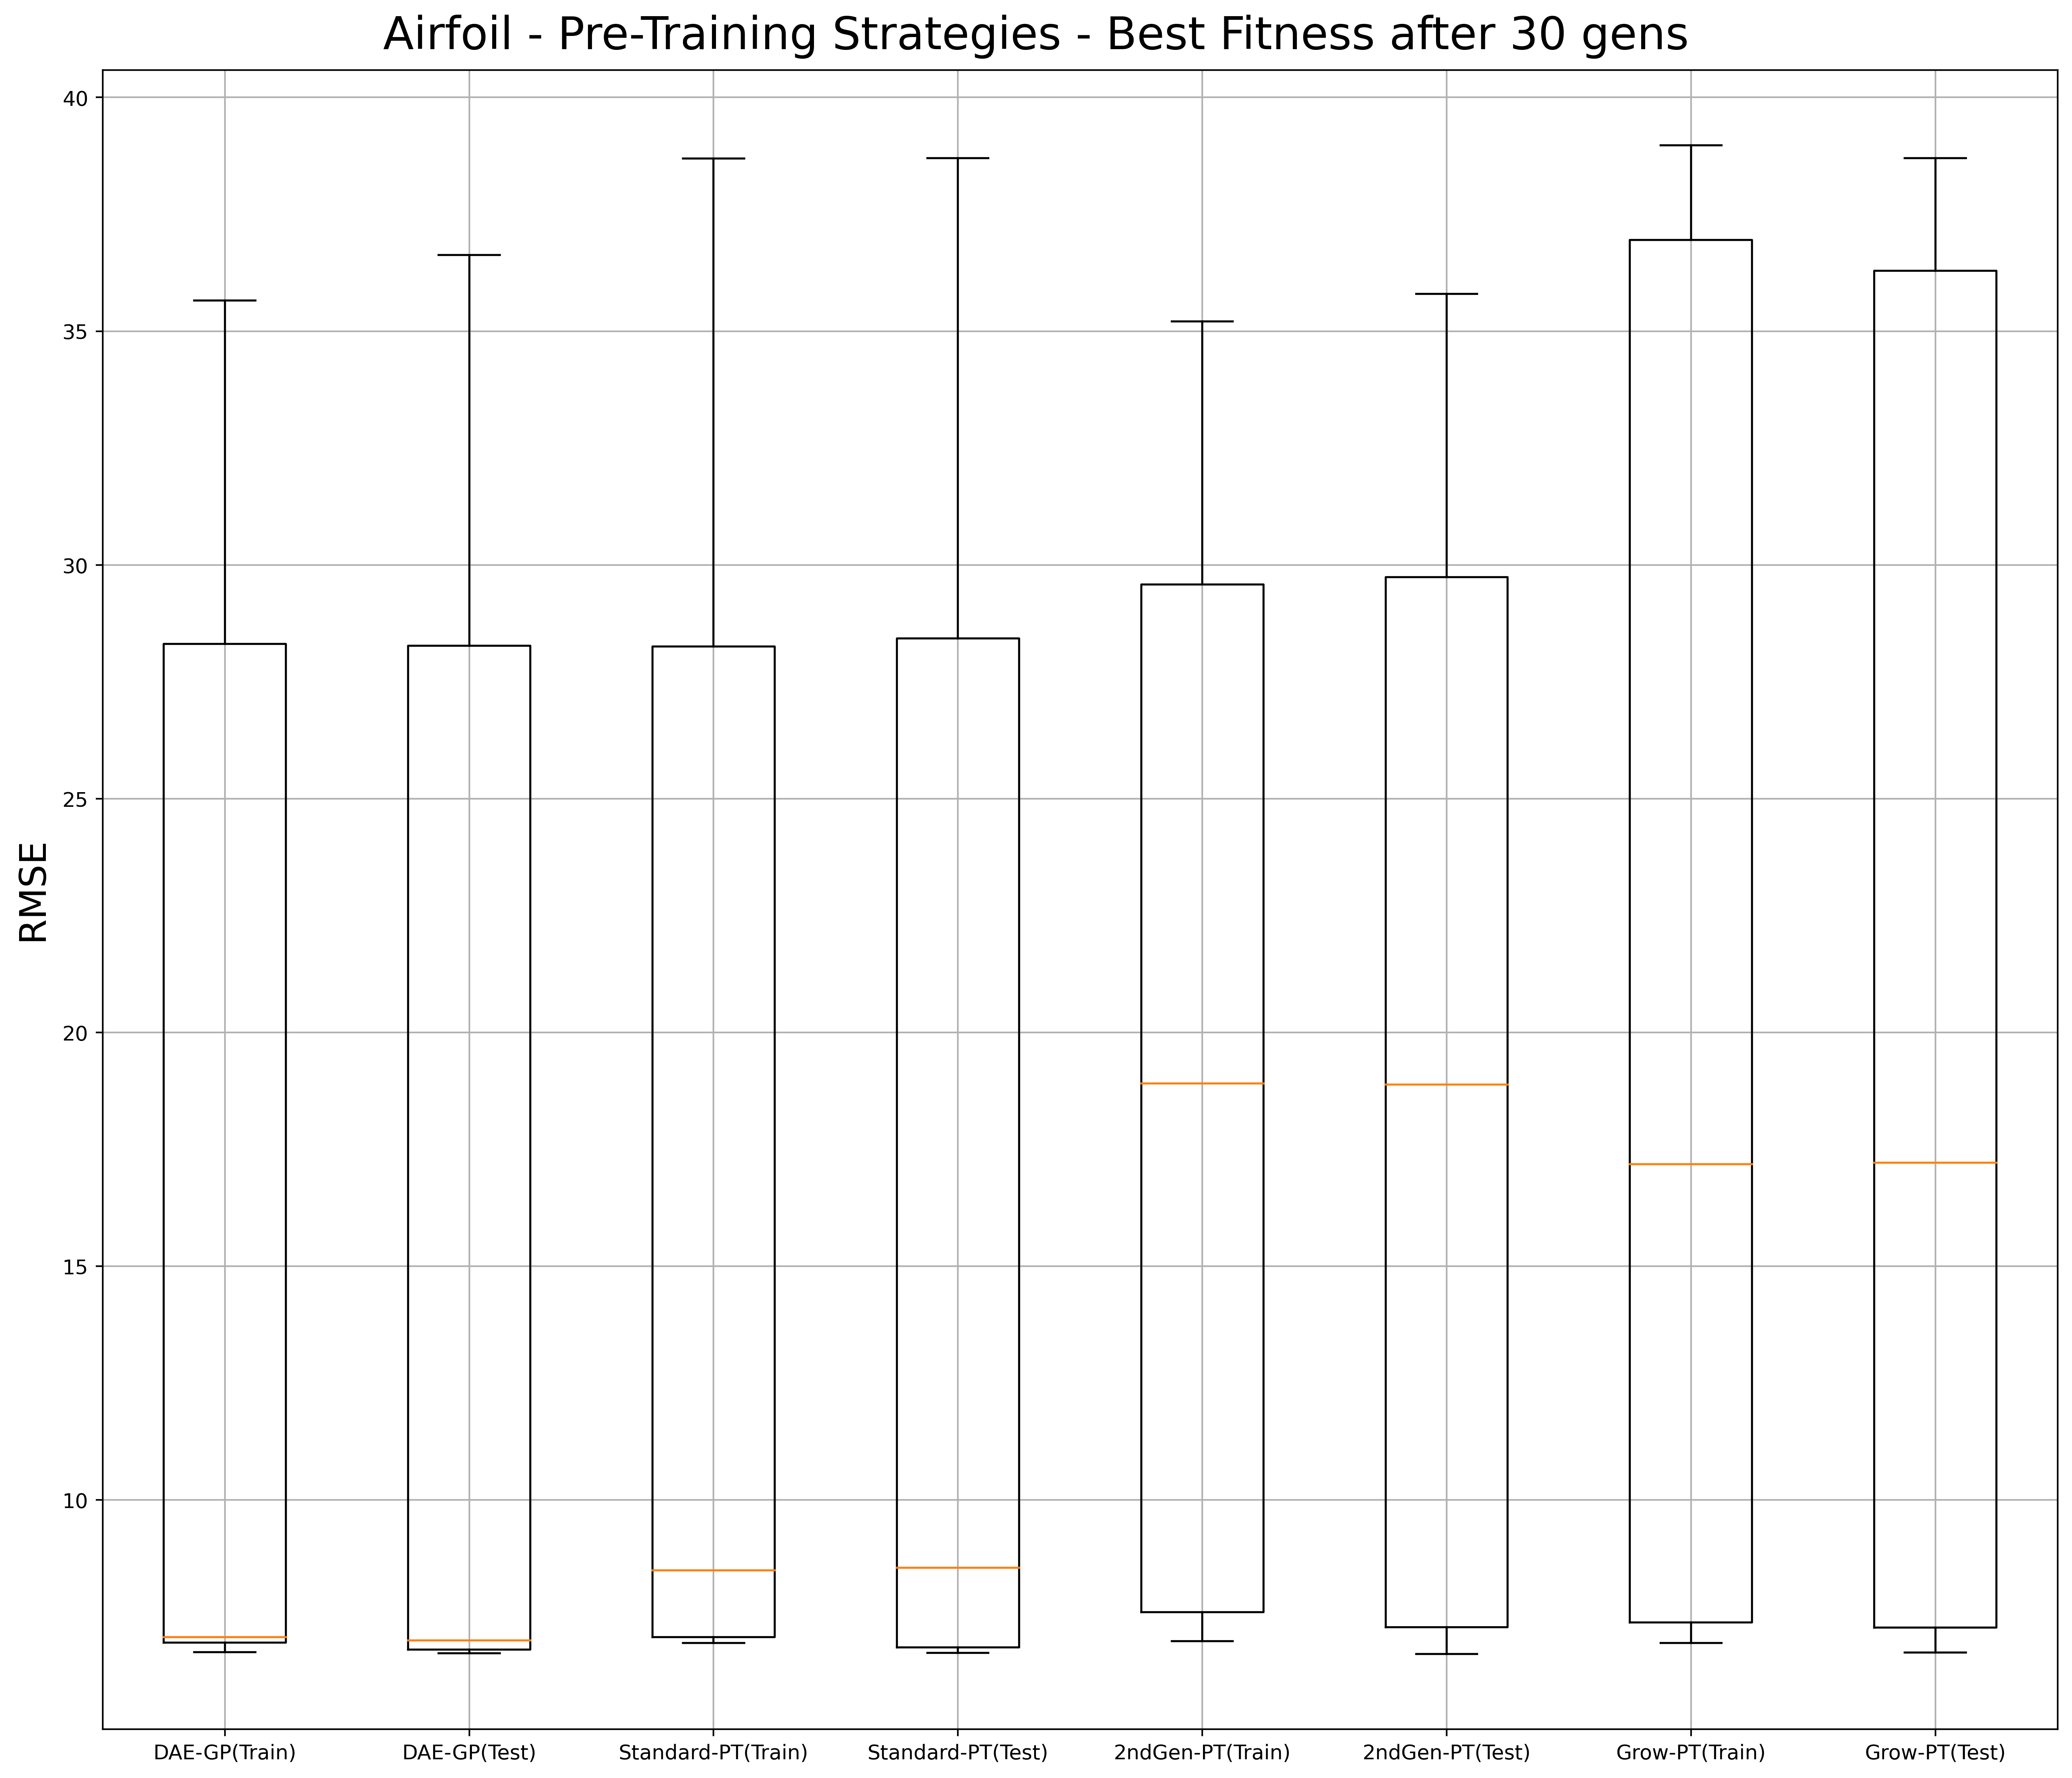

In [171]:
def last_fits(arr):
    ret = []
    for run in arr:
        ret.append(run[-1])
    return ret



fig, ax = plt.subplots(layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)

LABELS = ["DAE-GP(Train)", "DAE-GP(Test)", "Standard-PT(Train)", "Standard-PT(Test)", "2ndGen-PT(Train)", "2ndGen-PT(Test)", "Grow-PT(Train)", "Grow-PT(Test)"]
X = np.array([
    last_fits(reg_fits),
    last_fits(reg_fits_test),
    last_fits(s_pt_fits),
    last_fits(s_pt_fits_test),
    last_fits(sec_pt_fits),
    last_fits(sec_pt_fits_test),
    last_fits(grow_pt_fits),
    last_fits(grow_pt_fits_test)
], dtype=object)


std_dev = [np.std(x) for x in X]
means = [np.mean(x) for x in X]

fig.suptitle(f"{BASE_TITLE} - Best Fitness after 30 gens", fontsize=BIG)
fig.supylabel("RMSE", fontsize=MID)

bp_dict = ax.boxplot(
    x=X,
    labels=LABELS,
    #patch_artist=True,  # fill with color
    #notch=True,  # notch shape
)

# for i, line in enumerate(bp_dict['medians']):
#     x, y = line.get_xydata()[1]
#     text = ' mean={:.2f}\n std_dev={:.2f}'.format(means[i], std_dev[i])
#     ax.annotate(text, xy=(x, y))


ax.grid()
fig.savefig(f"{IMG_PATH}/final_fit_boxplot(train_test).png")



In [181]:
def last_fits(arr):
    ret = []
    for run in arr:
        ret.append(run[-1])
    return ret



fig, ax = plt.subplots(layout="constrained", sharex=True, sharey=True, dpi=DPI)
fig.set_size_inches(14,12)

LABELS = ["DAE-GP", "Standard-PT", "2ndGen-PT", "Grow-PT"]
X = np.array([
    last_fits(reg_fits_test),
    last_fits(s_pt_fits_test),
    last_fits(sec_pt_fits_test),
    last_fits(grow_pt_fits_test)
], dtype=object)


std_dev = [np.std(x) for x in X]
median = [np.median(x) for x in X]

fig.suptitle(f"{BASE_TITLE} - Best Fitness after 30 gens (Test Set)", fontsize=BIG)
fig.supylabel("RMSE", fontsize=MID)

bp_dict = ax.boxplot(
    x=X,
    labels=LABELS,
)

for i, line in enumerate(bp_dict['medians']):
    x, y = line.get_xydata()[1]
    text = ' median={:.2f}\n std_dev={:.2f}'.format(median[i], std_dev[i])
    ax.annotate(text, xy=(x, y))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=MID)


ax.grid()
fig.savefig(f"{IMG_PATH}/final_fit_boxplot(test_only).png")



In [173]:
# # number of evals per generation


# reg_nevals = get_vals(reg_results, "fitness_nevals", 30)
# pt_nevals = get_vals(pt_results, "fitness_nevals", 30)


# reg_nevals_mean = get_means(reg_nevals)
# pt_nevals_mean = get_means(pt_nevals)



# fig, ax = plt.subplots(layout="constrained", sharex=True, dpi=DPI)
# fig.set_size_inches(14,12)
# gens = [x for x in range(0, 31)]


# fig.suptitle(f"{BASE_TITLE} - Mean Number of Fitness Evaluations", fontsize=BIG)

# fig.supxlabel("Generations", fontsize=MID)

# ax.set_ylabel("Number of Fitness Evaluations")
# ax.plot(gens, reg_nevals_mean, color=C_REG, label="DAE-GP")
# ax.plot(gens, pt_nevals_mean, color=C_PT, label="Pre-Trained")

# ax.grid()

# ax.legend(fontsize=MID)


# fig.savefig(f"{IMG_PATH}/mean_nevals_byGens.png")


In [174]:
# plot total runtime

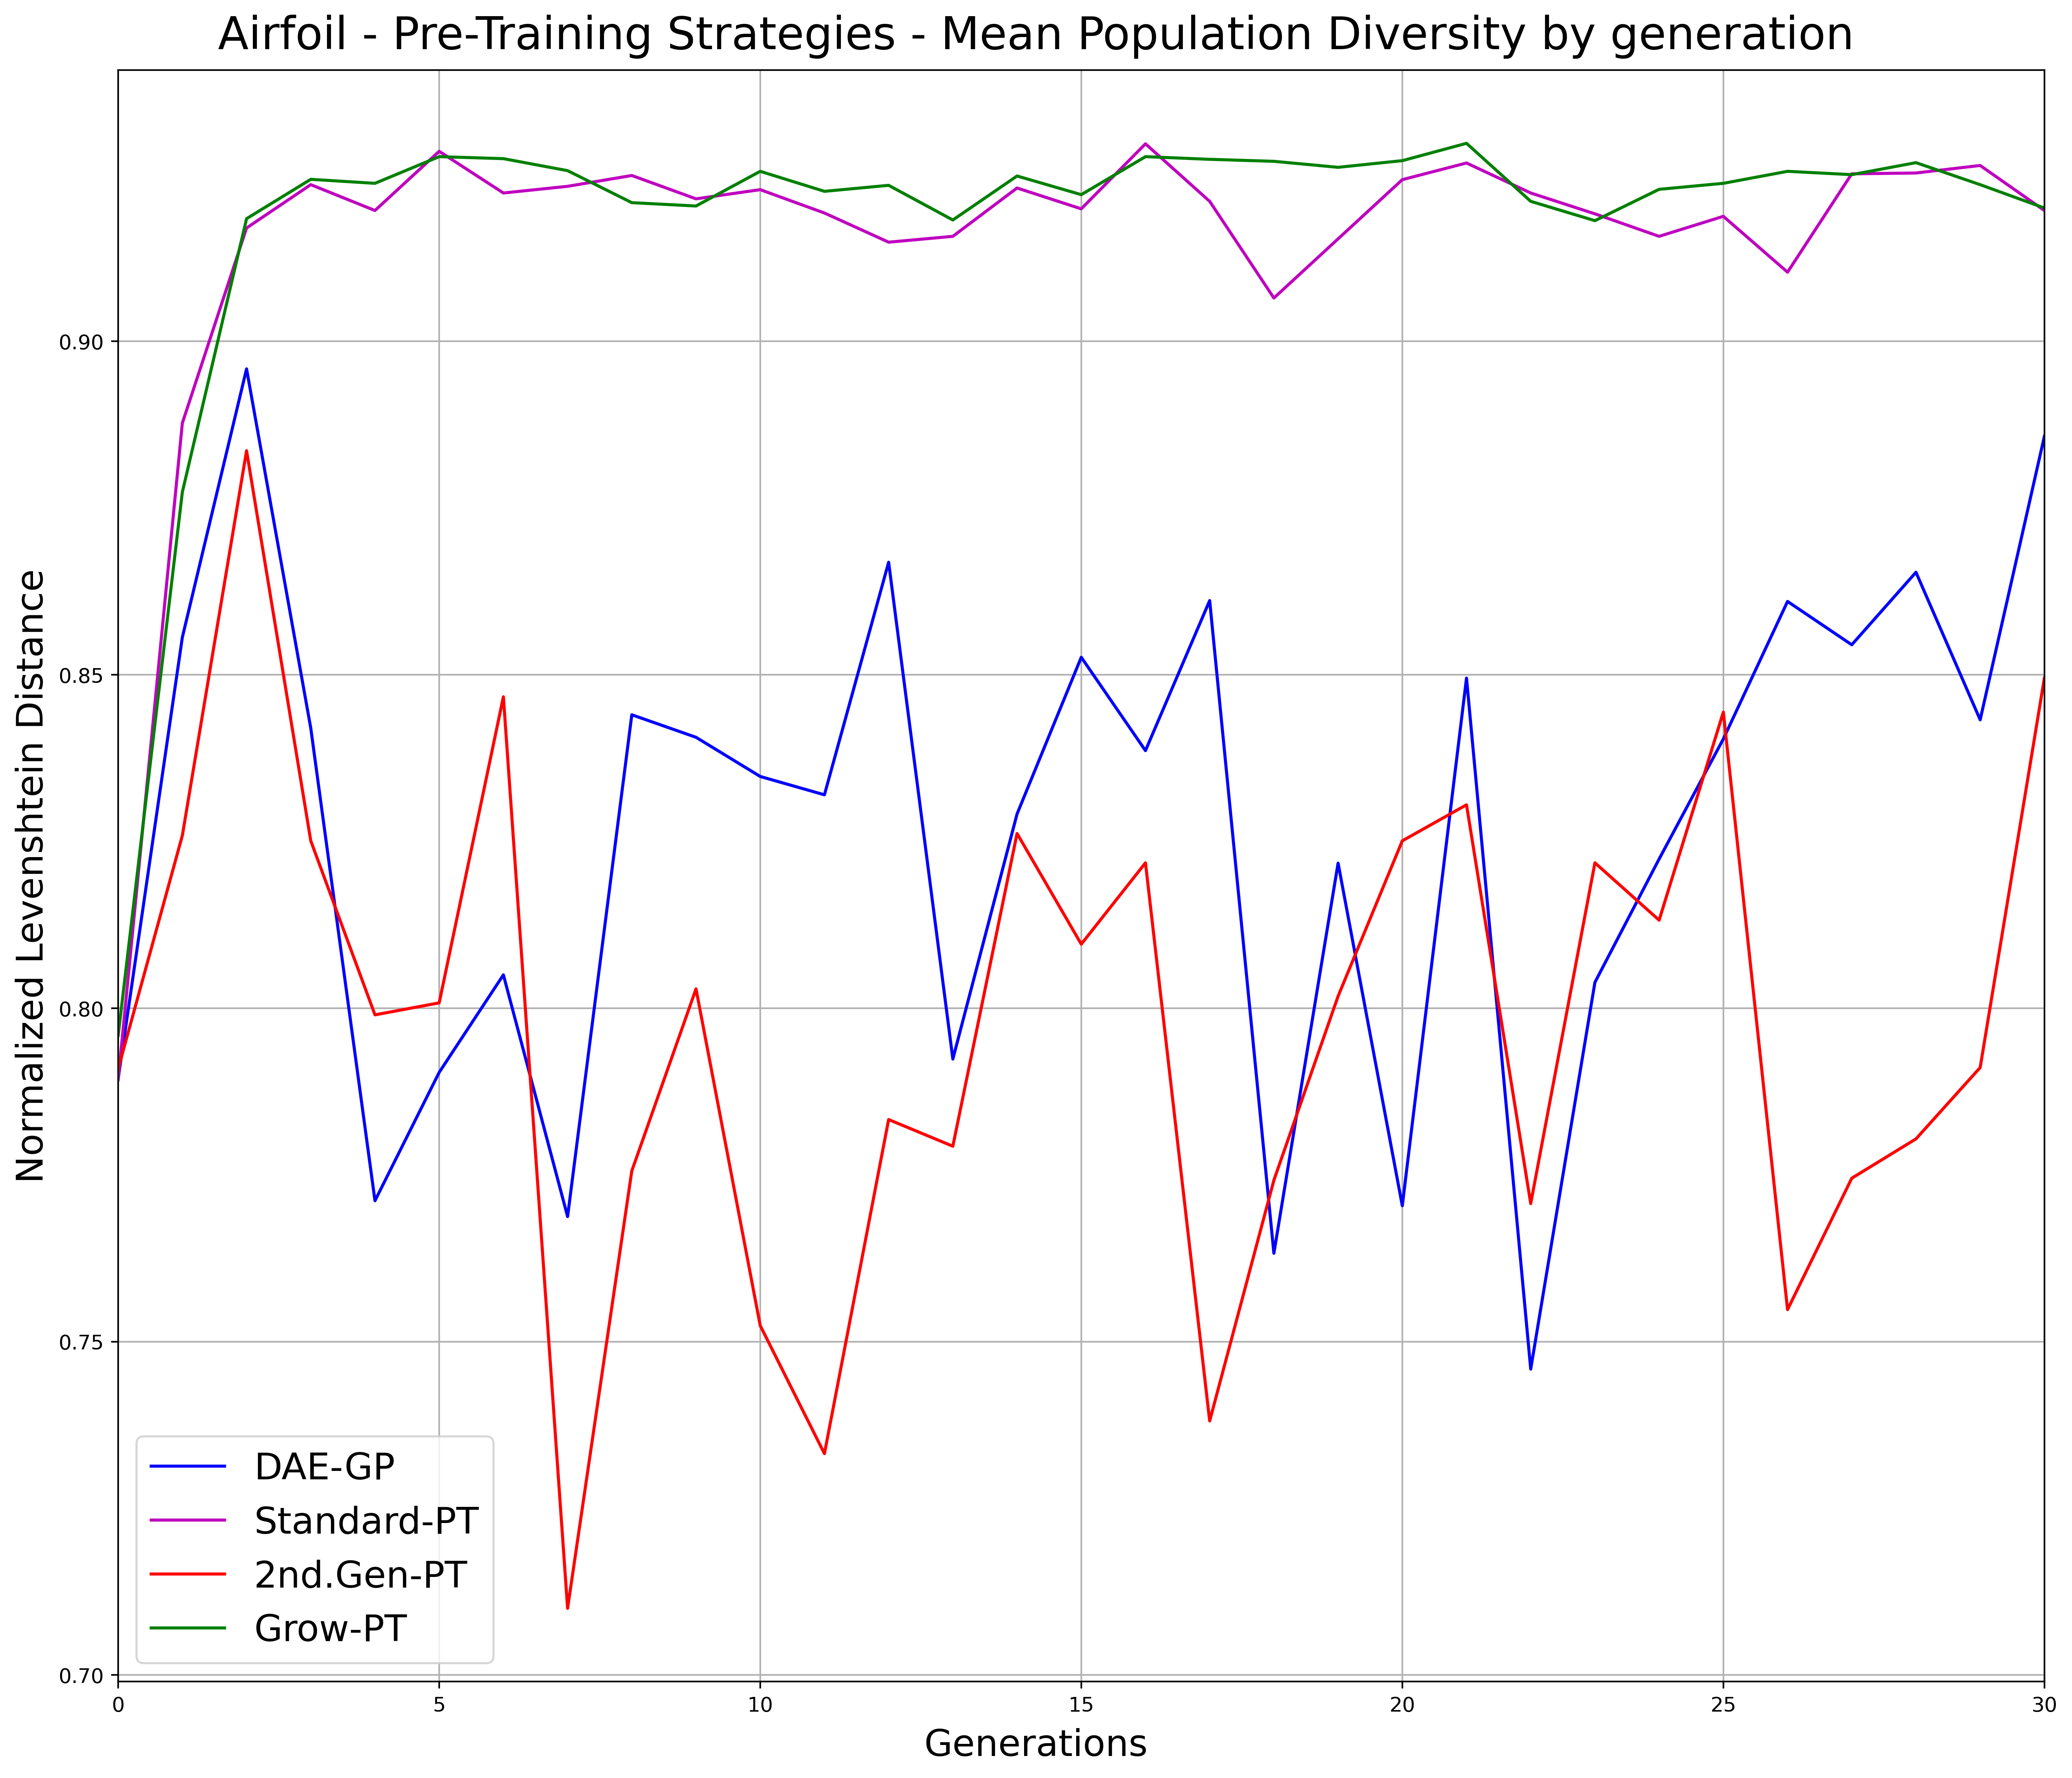

In [175]:
#  mean lev diversity per generation

reg_levdiv = get_vals(reg_results, "norm_lev_div", 30)
sec_pt_levdiv = get_vals(sec_pt_results, "norm_lev_div", 30)
grow_pt_levdiv = get_vals(grow_pt_results, "norm_lev_div", 30)
s_pt_levdiv = get_vals(s_pt_results, "norm_lev_div", 30)


reg_levdiv_mean = np.mean(reg_levdiv, axis=0)
sec_pt_levdiv_mean = np.mean(sec_pt_levdiv, axis=0)
grow_pt_levdiv_mean = np.mean(grow_pt_levdiv, axis=0)
s_pt_levdiv_mean = np.mean(s_pt_levdiv, axis=0)




fig, (axr) = plt.subplots(ncols=1, layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

axr.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - Mean Population Diversity by generation", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axr.set_ylabel("Normalized Levenshtein Distance",  fontsize=MID)
axr.plot(gens, reg_levdiv_mean, color=C_REG, label="DAE-GP")
axr.plot(gens, s_pt_levdiv_mean, color=C_SPT, label="Standard-PT")
axr.plot(gens, sec_pt_levdiv_mean, color=C_PT, label="2nd.Gen-PT")
axr.plot(gens, grow_pt_levdiv_mean, color=C_GP, label="Grow-PT")


axr.grid()

axr.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/mean_lev_div_overGens.png")


D = {
    "problem": "Airfoil",
    "hiddenLayer": 2,
    "DAE-GP": reg_levdiv,
    "2nd.Gen-Pre-Trained" : sec_pt_levdiv,
    "Grow-Pre-Trained" : grow_pt_levdiv,
    "Standard-Pre-Trained" : s_pt_levdiv
}

writeData(DATAPATH, "lev_div_overGens", D)

In [176]:
#  median lev diversity per generation

reg_levdiv = get_vals(reg_results, "norm_lev_div", 30)
sec_pt_levdiv = get_vals(sec_pt_results, "norm_lev_div", 30)
grow_pt_levdiv = get_vals(grow_pt_results, "norm_lev_div", 30)
s_pt_levdiv = get_vals(s_pt_results, "norm_lev_div", 30)


reg_levdiv_mean = np.median(reg_levdiv, axis=0)
sec_pt_levdiv_mean = np.median(sec_pt_levdiv, axis=0)
grow_pt_levdiv_mean = np.median(grow_pt_levdiv, axis=0)
s_pt_levdiv_mean = np.median(s_pt_levdiv, axis=0)





fig, (axr) = plt.subplots(ncols=1, layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

axr.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - Median Population Diversity by generation", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axr.set_ylabel("Normalized Levenshtein Distance",  fontsize=MID)
axr.plot(gens, reg_levdiv_mean, color=C_REG, label="DAE-GP")
axr.plot(gens, s_pt_levdiv_mean, color=C_SPT, label="Standard-PT")
axr.plot(gens, sec_pt_levdiv_mean, color=C_PT, label="2nd.Gen-PT")
axr.plot(gens, grow_pt_levdiv_mean, color=C_GP, label="Grow-PT")


axr.grid()

axr.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/median_lev_div_overGens.png")

In [177]:
# plot sample time

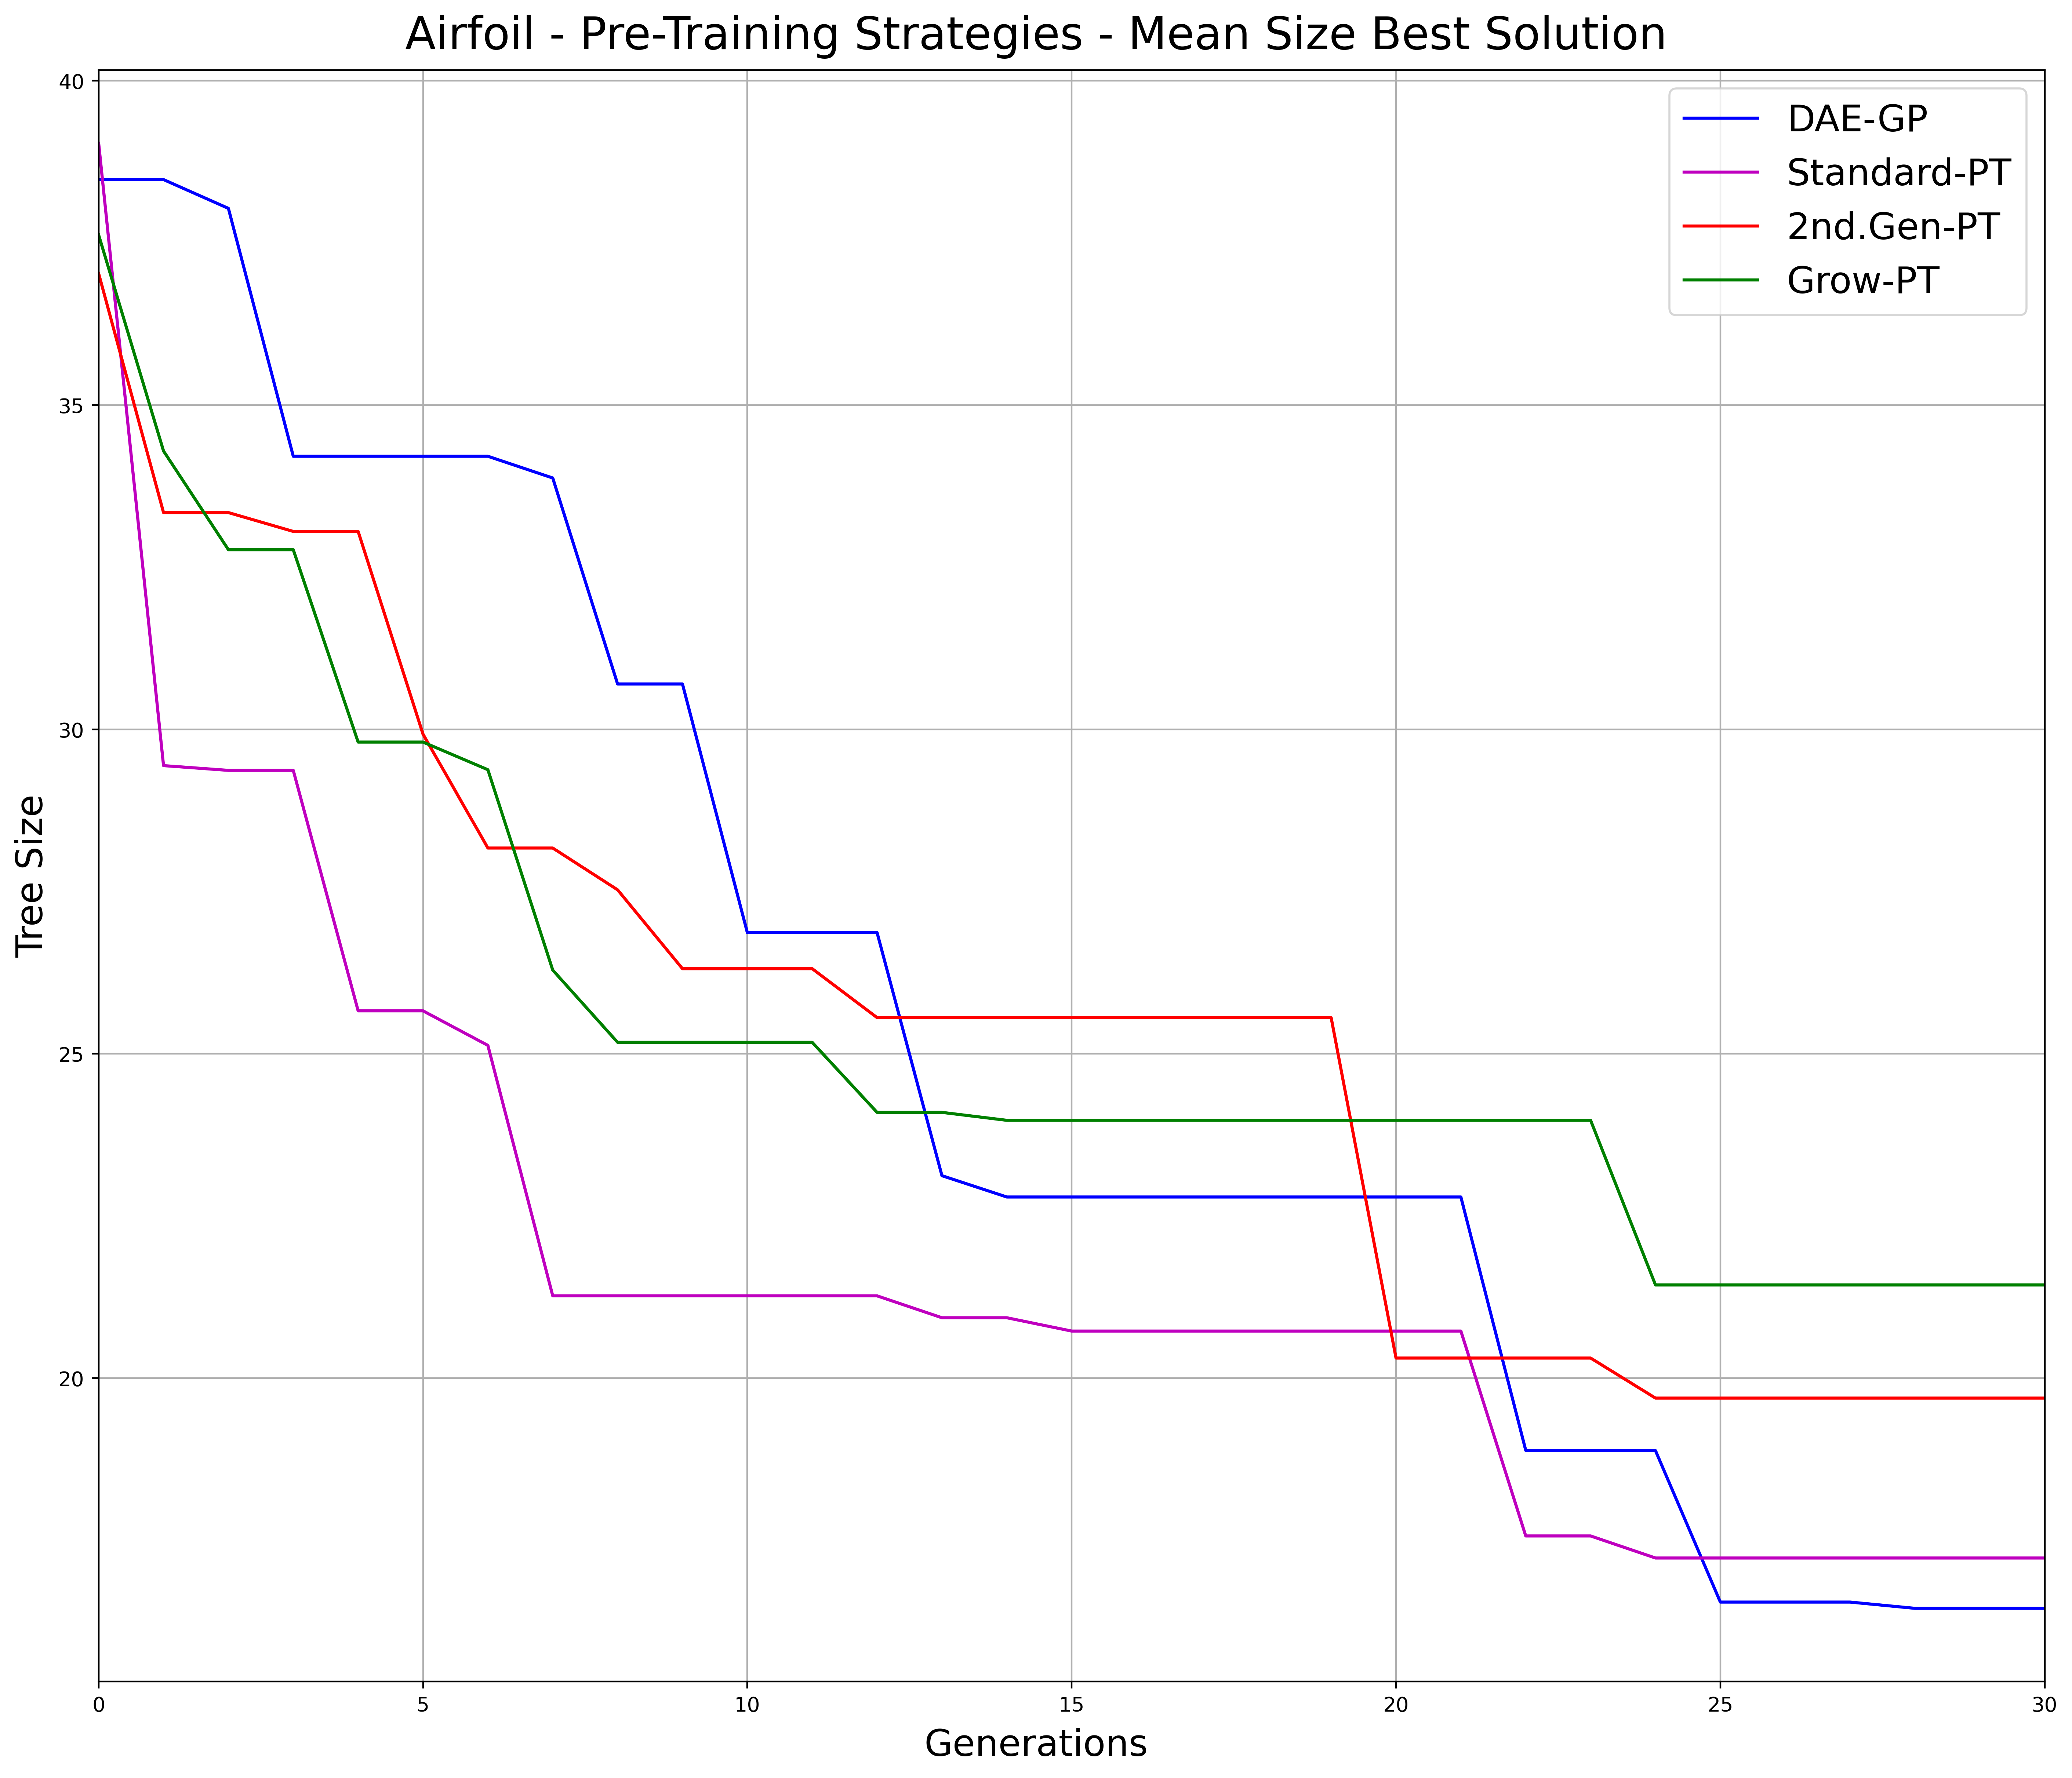

In [178]:
#  mean size_best_Solution

reg_levdiv = get_vals(reg_results, "size_best_fitness", 30)
sec_pt_levdiv = get_vals(sec_pt_results, "size_best_fitness", 30)
grow_pt_levdiv = get_vals(grow_pt_results, "size_best_fitness", 30)
s_pt_levdiv = get_vals(s_pt_results, "size_best_fitness", 30)


reg_levdiv_mean = np.mean(reg_levdiv, axis=0)
sec_pt_levdiv_mean = np.mean(sec_pt_levdiv, axis=0)
grow_pt_levdiv_mean = np.mean(grow_pt_levdiv, axis=0)
s_pt_levdiv_mean = np.mean(s_pt_levdiv, axis=0)




fig, (axr) = plt.subplots(ncols=1, layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

axr.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - Mean Size Best Solution", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axr.set_ylabel("Tree Size",  fontsize=MID)
axr.plot(gens, reg_levdiv_mean, color=C_REG, label="DAE-GP")
axr.plot(gens, s_pt_levdiv_mean, color=C_SPT, label="Standard-PT")
axr.plot(gens, sec_pt_levdiv_mean, color=C_PT, label="2nd.Gen-PT")
axr.plot(gens, grow_pt_levdiv_mean, color=C_GP, label="Grow-PT")


axr.grid()

axr.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/mean_Size_best_solution.png")

D = {
    "problem": "Airfoil",
    "hiddenLayer": 2,
    "DAE-GP": reg_levdiv,
    "2nd.Gen-Pre-Trained" : sec_pt_levdiv,
    "Grow-Pre-Trained" : grow_pt_levdiv,
    "Standard-Pre-Trained" : s_pt_levdiv
}

writeData(DATAPATH, "size_best_solution", D)

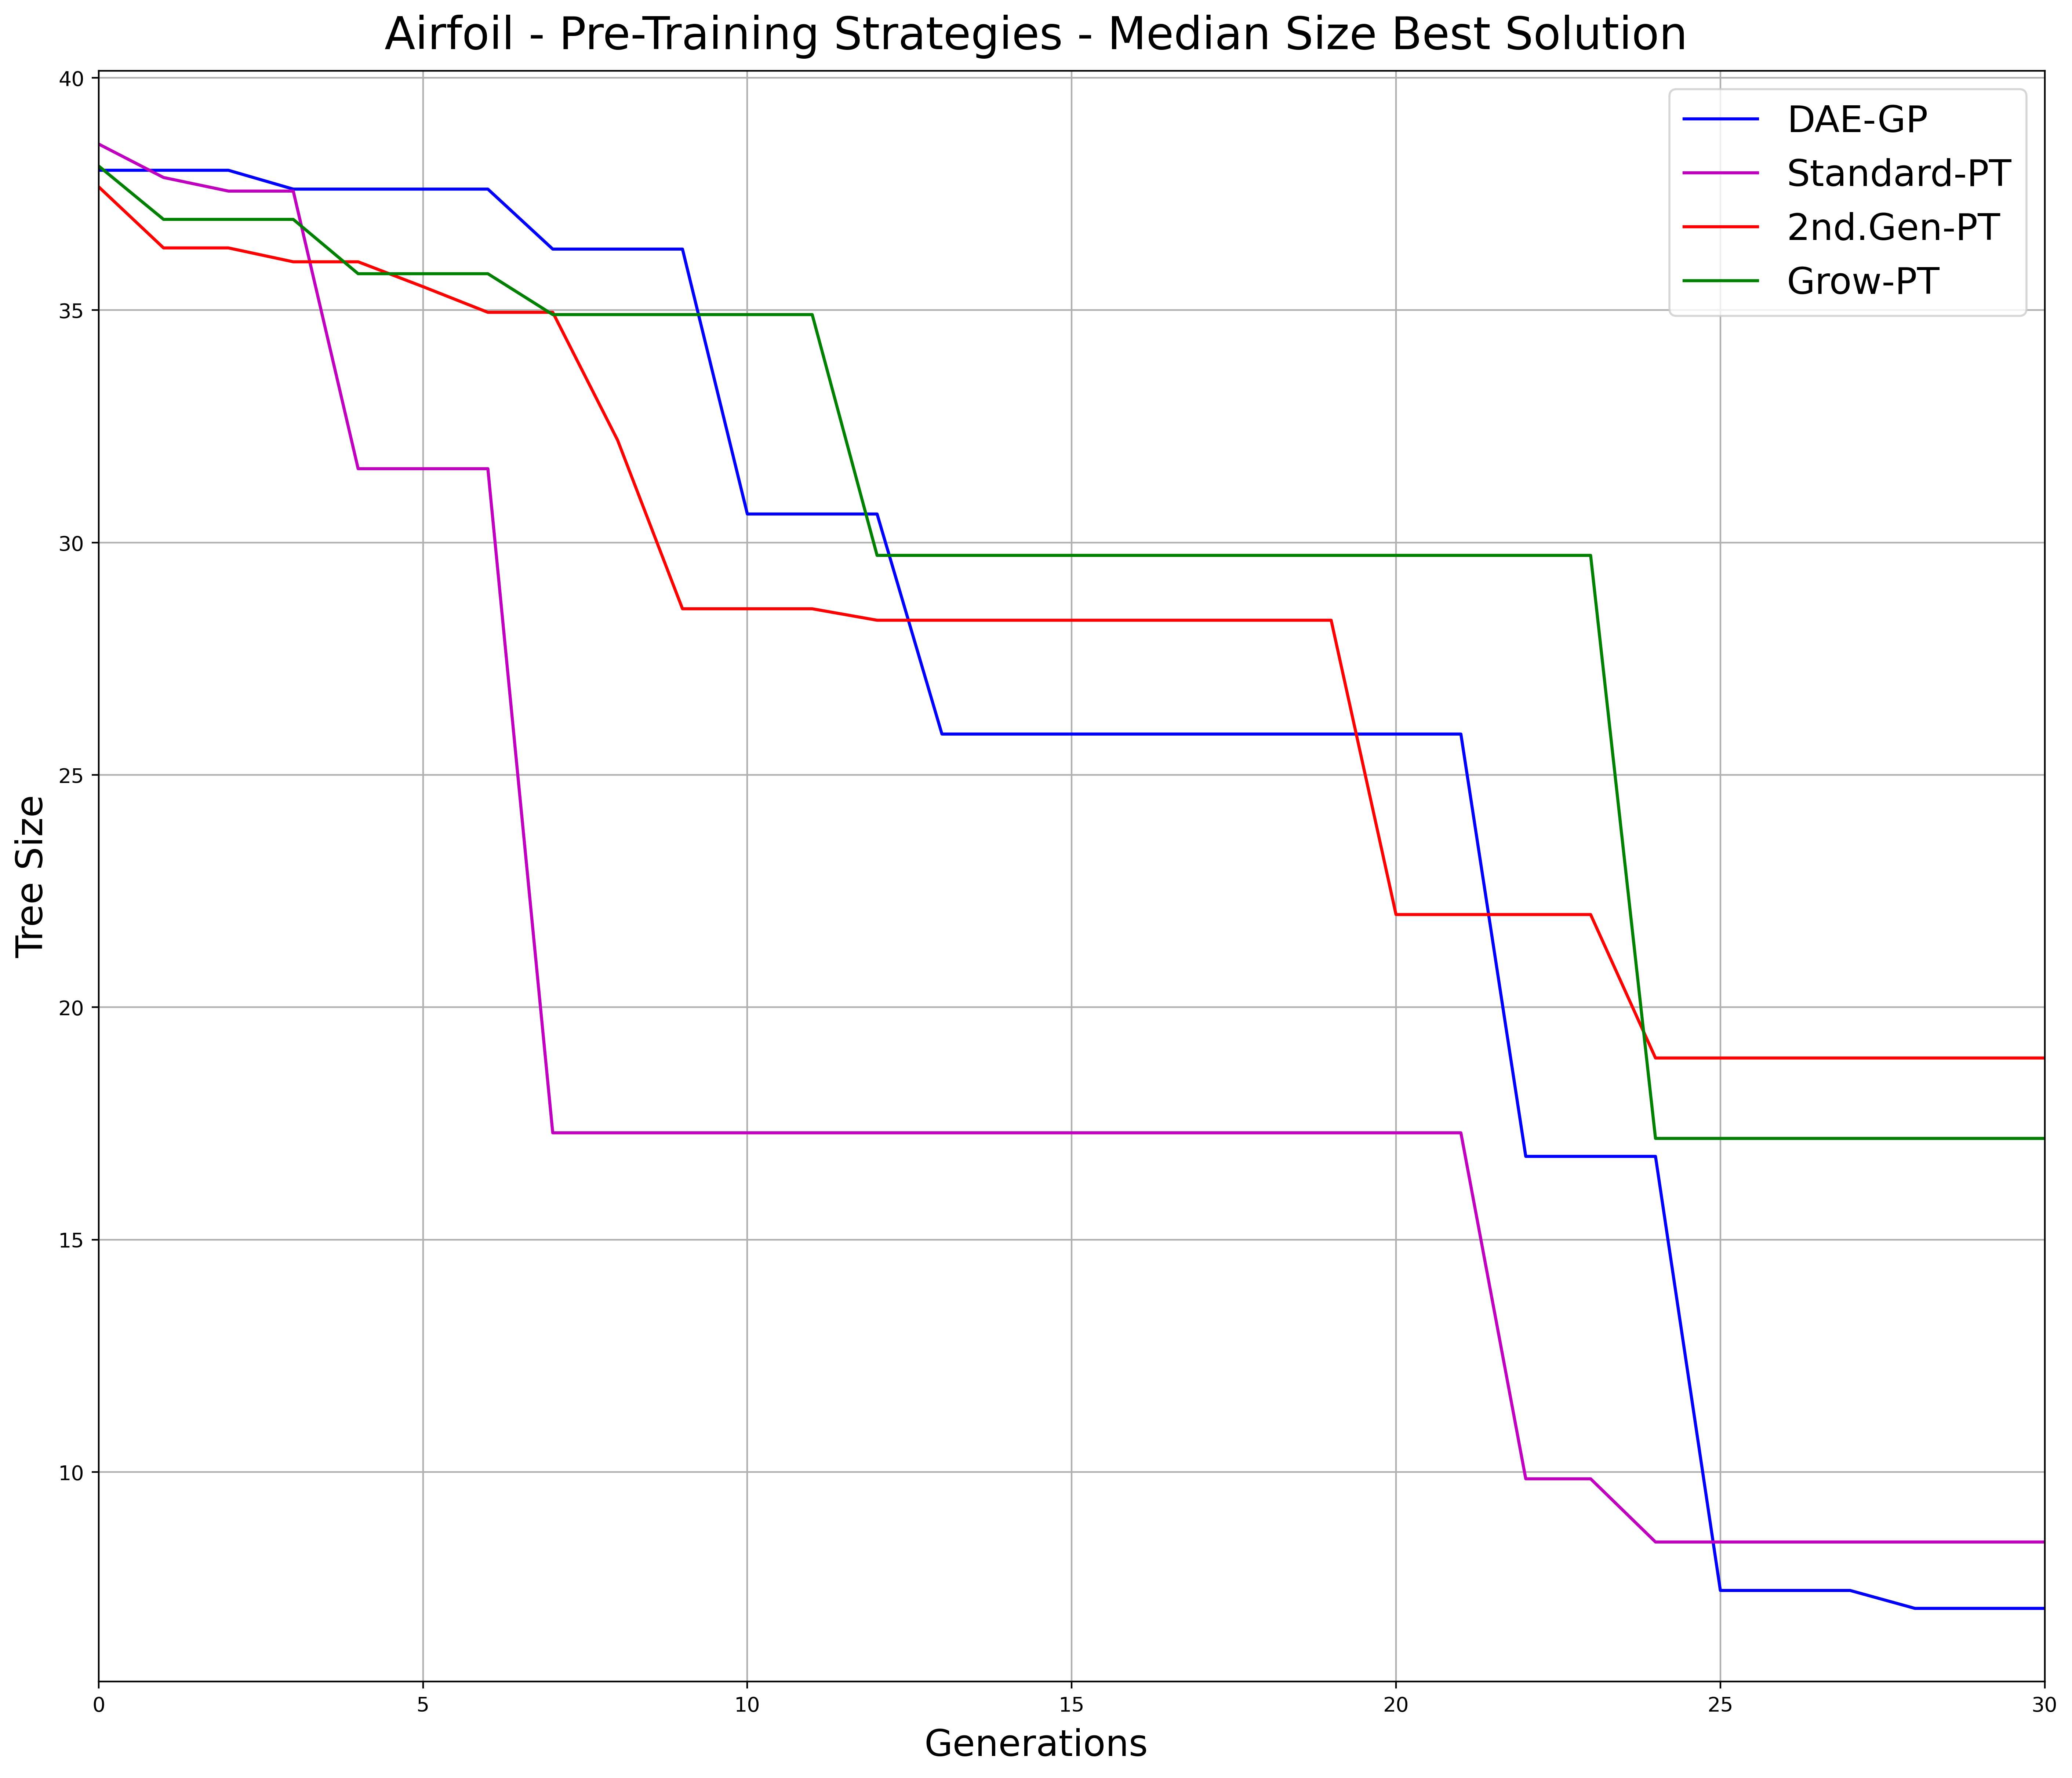

In [179]:
#  median size_best_Solution

reg_levdiv = get_vals(reg_results, "size_best_fitness", 30)
sec_pt_levdiv = get_vals(sec_pt_results, "size_best_fitness", 30)
grow_pt_levdiv = get_vals(grow_pt_results, "size_best_fitness", 30)
s_pt_levdiv = get_vals(s_pt_results, "size_best_fitness", 30)


reg_levdiv_mean = np.median(reg_levdiv, axis=0)
sec_pt_levdiv_mean = np.median(sec_pt_levdiv, axis=0)
grow_pt_levdiv_mean = np.median(grow_pt_levdiv, axis=0)
s_pt_levdiv_mean = np.median(s_pt_levdiv, axis=0)





fig, (axr) = plt.subplots(ncols=1, layout="constrained", sharex=True, dpi=DPI)
fig.set_size_inches(14,12)
gens = [x for x in range(0, 31)]

axr.set_xlim(left=0, right=30)


fig.suptitle(f"{BASE_TITLE} - Median Size Best Solution", fontsize=BIG)

fig.supxlabel("Generations", fontsize=MID)

axr.set_ylabel("Tree Size",  fontsize=MID)
axr.plot(gens, reg_levdiv_mean, color=C_REG, label="DAE-GP")
axr.plot(gens, s_pt_levdiv_mean, color=C_SPT, label="Standard-PT")
axr.plot(gens, sec_pt_levdiv_mean, color=C_PT, label="2nd.Gen-PT")
axr.plot(gens, grow_pt_levdiv_mean, color=C_GP, label="Grow-PT")



axr.grid()

axr.legend(fontsize=MID)


fig.savefig(f"{IMG_PATH}/median_Size_best_solution.png")

In [180]:
import datetime

def print_current_date_and_time():
  now = datetime.datetime.now()
  print(f'Notebook last executed at: {now.strftime("%Y-%m-%d %H:%M:%S")}')

print_current_date_and_time()

Notebook last executed at: 2023-01-22 12:40:38
